In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
df = pd.read_csv("uber.csv")
df.head()

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5


In [4]:
# Drop rows with null values
df.dropna(inplace=True)
# Remove invalid fare values
df = df[(df['fare_amount'] > 0) & (df['fare_amount'] < 100)]
# Remove invalid coordinates
df = df[
(df['pickup_latitude'].between(-90, 90)) &
(df['pickup_longitude'].between(-180, 180)) &
(df['dropoff_latitude'].between(-90, 90)) &
(df['dropoff_longitude'].between(-180, 180))
]
# Convert datetime
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'], errors='coerce')
df.dropna(subset=['pickup_datetime'], inplace=True)


In [5]:
def haversine(lat1, lon1, lat2, lon2):
    R = 6371 # Earth radius in km
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c

df['distance_km'] = haversine(
    df['pickup_latitude'], df['pickup_longitude'],
    df['dropoff_latitude'], df['dropoff_longitude']
)

# Remove zero or unrealistic distances
df = df[(df['distance_km'] > 0) & (df['distance_km'] < 100)]

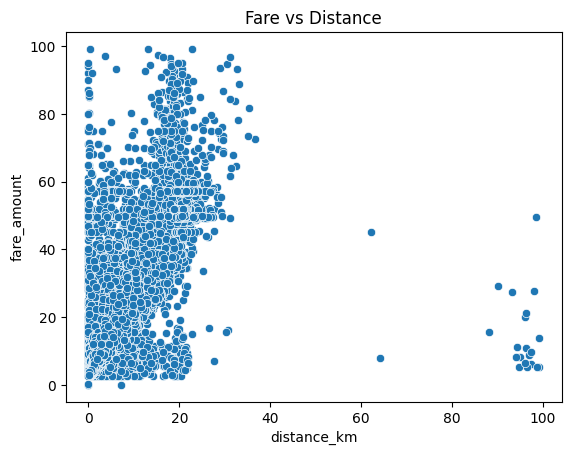

In [6]:
sns.scatterplot(x=df['distance_km'], y=df['fare_amount'])
plt.title("Fare vs Distance")
plt.show()


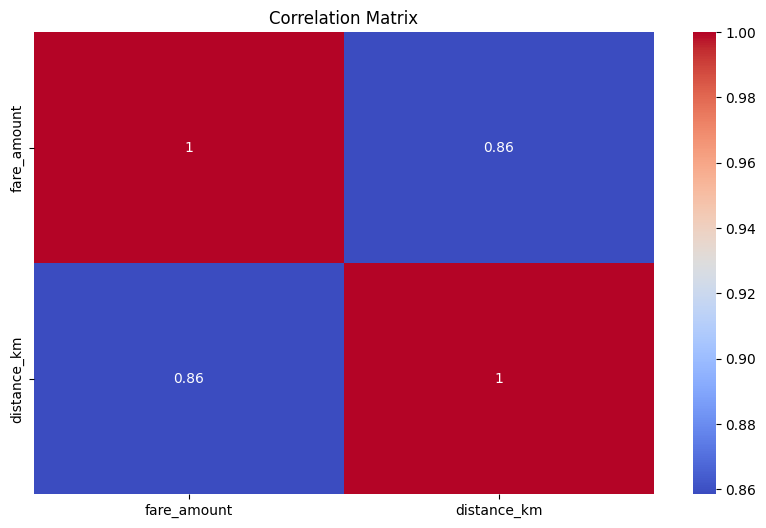

In [7]:
plt.figure(figsize=(10,6))
sns.heatmap(df[['fare_amount', 'distance_km']].corr(), annot=True,cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

In [8]:
X = df[['distance_km']]
y = df['fare_amount']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

In [9]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)
print("Linear Regression R2 Score:", r2_score(y_test, y_pred_lr))
print("Linear Regression RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_lr)))


Linear Regression R2 Score: 0.7175274133644127
Linear Regression RMSE: 4.995326068516896


In [10]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
print("Random Forest R2 Score:", r2_score(y_test, y_pred_rf))
print("Random Forest RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_rf)))


Random Forest R2 Score: 0.7059615993547173
Random Forest RMSE: 5.09656672504093


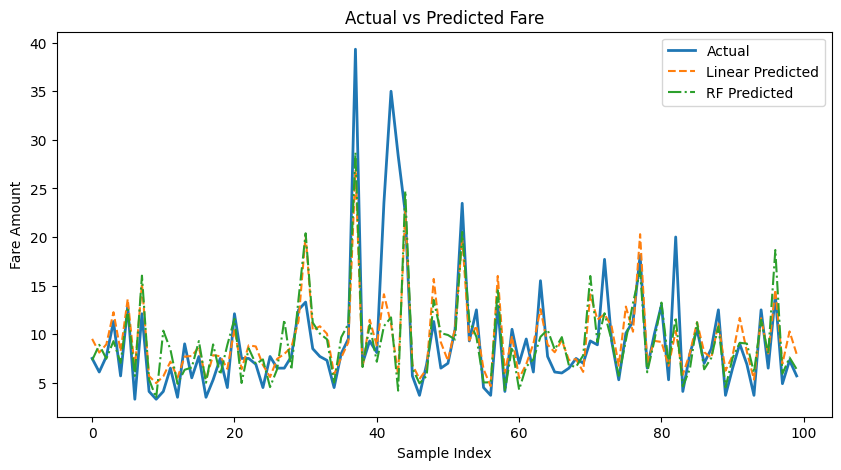

In [16]:
plt.figure(figsize=(10,5))
plt.plot(y_test.values[:100], label='Actual', linewidth=2)
plt.plot(y_pred_lr[:100], label='Linear Predicted', linestyle='--')
plt.plot(y_pred_rf[:100], label='RF Predicted', linestyle='-.')
plt.title("Actual vs Predicted Fare")
plt.xlabel("Sample Index")
plt.ylabel("Fare Amount")
plt.legend()
plt.show()
